In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch as torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset, random_split
from sklearn.metrics import r2_score
import math

if torch.cuda.is_available():    
    device = "cuda:0"
else:
    device = "cpu"
print(device)

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import torch.optim as optim

cuda:0


### Data Preparation

Let's first import all the datasets associated to the experimental curves in train and test sets. We will reshape these data as needed.

In [2]:
# Load the train and test sets
X_train_raw = np.load("./data/training_curves.npy")
X_test_raw = np.load("./data/testing_curves.npy")

Plot some examples:

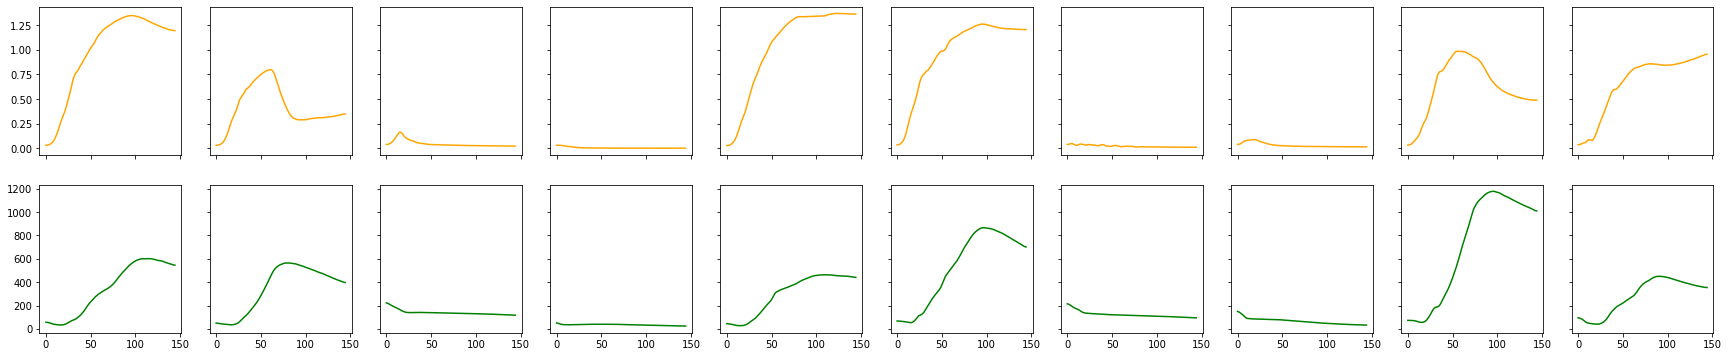

In [3]:
fig, axs = plt.subplots(2, 10, figsize = (30,6), sharex = True, sharey = "row")
for col in range(10):
    j = np.random.randint(X_train_raw.shape[0])
    axs[0,col].plot(X_train_raw[j,1,:], color = 'orange')
    axs[1,col].plot(X_train_raw[j,2,:], color = 'green')
plt.show()

In [4]:
X_train_raw.shape

(2400, 4, 145)

We are only interested in the OD600 and GFP dynamics in this system. We will study this by concatenating these two curves together and then min-max scale them.

## VAE Compression

Next we'll treat VAE compression of these data using a simple convolutional encoder/decoder structure. We'll use a simple CNN encoder/decoder structure for generating our embeddings where we first apply convolutional operators to generate features and then linear layers to embed into the desired latent space. 

In [5]:
initial_channels = 64
class CNNEncoder(nn.Module):
    def __init__(self, latent_dim):
        super(CNNEncoder, self).__init__()
        self.latent_dim = latent_dim

        layers = [
            nn.Conv1d(1, initial_channels, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU()
        ]

        in_channels = initial_channels
        for i in range(3):  # 3 more layers to make 4 in total
            out_channels = in_channels // 2
            layers.extend([
                nn.Conv1d(in_channels, out_channels, kernel_size=3, stride=1, padding=1),
                nn.LeakyReLU()
            ])
            in_channels = out_channels

        self.encoder = nn.Sequential(*layers)
        self.fc_mean = nn.Linear(in_channels * seq_length, latent_dim)
        self.fc_logvar = nn.Linear(in_channels * seq_length, latent_dim)

    def forward(self, x):
        x = self.encoder(x)
        x = x.view(x.size(0), -1)
        mean = self.fc_mean(x)
        logvar = self.fc_logvar(x)
        return mean, logvar

class CNNDecoder(nn.Module):
    def __init__(self, latent_dim):
        super(CNNDecoder, self).__init__()
        self.latent_dim = latent_dim
        self.fc = nn.Linear(latent_dim, initial_channels // 8 * seq_length)  # Match the output channel of the encoder

        layers = [nn.LeakyReLU()]
        in_channels = initial_channels // 8
        for i in range(3):
            out_channels = in_channels * 2
            layers.extend([
                nn.ConvTranspose1d(in_channels, out_channels, kernel_size=3, stride=1, padding=1),
                nn.LeakyReLU()
            ])
            in_channels = out_channels
        
        # Remove the last LeakyReLU and add a final ConvTranspose to match the Encoder's starting channel
        layers.pop()
        layers.append(nn.LeakyReLU())
        layers.append(nn.ConvTranspose1d(in_channels, 1, kernel_size=3, stride=1, padding=1))

        self.decoder = nn.Sequential(*layers)

    def forward(self, z):
        x = self.fc(z)
        x = x.view(x.size(0), initial_channels // 8, seq_length)
        x = self.decoder(x)
        return F.leaky_relu(x)

class MLPEncoder(nn.Module):
    def __init__(self, initial_dim, latent_dim):
        super(MLPEncoder, self).__init__()
        self.initial_dim = initial_dim
        self.latent_dim = latent_dim

        layers = []
        # Find the largest power of two smaller than initial_dim
        in_features = 2 ** (math.floor(math.log2(initial_dim)))
        
        layers.extend([
            nn.Linear(initial_dim, in_features),
            nn.LeakyReLU()
        ])
        
        final_dim = 2 ** (math.ceil(math.log2(latent_dim)))
        while in_features > final_dim:
            out_features = in_features // 2
            layers.extend([
                nn.Linear(in_features, out_features),
                nn.LeakyReLU()
            ])
            in_features = out_features
    

        self.encoder = nn.Sequential(*layers)
        self.fc_mean = nn.Linear(in_features, latent_dim)
        self.fc_logvar = nn.Linear(in_features, latent_dim)

    def forward(self, x):
        x = self.encoder(x)
        mean = self.fc_mean(x)
        logvar = self.fc_logvar(x)
        return mean, logvar


class MLPDecoder(nn.Module):
    def __init__(self, latent_dim, output_dim):
        super(MLPDecoder, self).__init__()
        self.latent_dim = latent_dim
        self.output_dim = output_dim

        layers = []
        
        in_features = 2 ** (math.ceil(math.log2(latent_dim)))
        layers.extend([
            nn.Linear(latent_dim, in_features),
            nn.LeakyReLU()
        ])
        
        final_size = 2 ** (math.floor(math.log2(output_dim)))
        while in_features < final_size:
            out_features = in_features * 2
            layers.extend([
                nn.Linear(in_features, out_features),
                nn.LeakyReLU()
            ])
            in_features = out_features

        # Adding the last layer to reach one power of two smaller than output_dim
        layers.extend([
            nn.Linear(in_features, output_dim),
            nn.LeakyReLU()
        ])

        self.decoder = nn.Sequential(*layers)

    def forward(self, x):
        return self.decoder(x)
    
class VAE(nn.Module):
    def __init__(self, latent_dim):
        super(VAE, self).__init__()
        self.latent_dim = latent_dim
        self.encoder = CNNEncoder(latent_dim)
        self.decoder = CNNDecoder(latent_dim)

    def reparameterize(self, mean, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mean + eps * std

    def forward(self, x):
        mean, logvar = self.encoder(x)
        z = self.reparameterize(mean, logvar)
        reconstruction = self.decoder(z)
        return reconstruction, mean, logvar
    
    def get_embedding(self, x):
        self.eval()
        with torch.no_grad():
            mean, logvar = self.encoder(x)
            z = self.reparameterize(mean, logvar)
        return z
    
class SimpleVAE(nn.Module):
    def __init__(self, initial_dim, latent_dim):
        super(SimpleVAE, self).__init__()
        self.latent_dim = latent_dim
        self.encoder = MLPEncoder(initial_dim, latent_dim)
        self.decoder = MLPDecoder(latent_dim, initial_dim)

    def reparameterize(self, mean, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mean + eps * std

    def forward(self, x):
        mean, logvar = self.encoder(x)
        z = self.reparameterize(mean, logvar)
        reconstruction = self.decoder(z)
        return reconstruction, mean, logvar
    
    def get_embedding(self, x):
        self.eval()
        with torch.no_grad():
            mean, logvar = self.encoder(x)
            z = self.reparameterize(mean, logvar)
        return z

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def train(model, dataloader, optimizer, criterion, alpha):
    model.train()
    running_loss = 0
    for data in dataloader:
        data = data.to(device)
        optimizer.zero_grad()

        reconstruction, mean, logvar = model(data)
        recon_loss = criterion(reconstruction, data)
        kl_loss = -0.5 * torch.mean(1 + logvar - mean.pow(2) - logvar.exp())
        loss = recon_loss + alpha * kl_loss

        loss.backward()
        optimizer.step()

        running_loss += loss.item() * data.size(0)
        
    epoch_loss = running_loss / len(dataloader.dataset)
    return epoch_loss

def test(model, dataloader, criterion):
    model.eval()
    running_loss = 0
    with torch.no_grad():
        for data in dataloader:
            data = data.to(device)
            reconstruction, _, _ = model(data)
            loss = criterion(reconstruction, data)

            running_loss += loss.item() * data.size(0)
    
    epoch_loss = running_loss / len(dataloader.dataset)
    return epoch_loss

def get_latent_variables(model, dataloader):
    model.eval()
    all_latent_vars = []
    with torch.no_grad():
        for data in dataloader:
            data = data.to(device)
            _, mean, _ = model(data)
            all_latent_vars.append(mean.detach().cpu())
    return torch.cat(all_latent_vars)

We'll now break up the training and testing sets apart and load them into dataloader. While we're at it we'll also go ahead and define a hyperparameter dictionary to collect all hyperparameters of interest in a single location.

In [6]:
# Define the hyperparameters
batch_size = 2000
latent_dim = 10
alpha =  1e-3
lr= 1e-3
min_lr = 5e-6
epochs = 5000
gamma = 0.99
weight_decay= 1e-6
seq_length = 145*2

In [7]:
# Pull off data
ODs = X_train_raw[:,1,:]
GFPs = X_train_raw[:,2,:]

OD_max = ODs.max()
OD_min = ODs.min()
GFP_max = GFPs.max()
GFP_min = GFPs.min()

ODs = (ODs - ODs.min())/(ODs.max() - ODs.min())
GFPs = (GFPs - GFPs.min())/(GFPs.max() - GFPs.min())
X_train_reorg = np.hstack([ODs, GFPs])
train_data = torch.Tensor(X_train_reorg)#.unsqueeze(1)

ODs = X_test_raw[:,1,:]
GFPs = X_test_raw[:,2,:]

ODs = (ODs - OD_min)/(OD_max - OD_min)
GFPs = (GFPs - GFP_min)/(GFP_max - GFP_min)
X_test_reorg = np.hstack([ODs, GFPs])
test_data = torch.Tensor(X_test_reorg)#.unsqueeze(1)


# el = np.random.randint(ODs.shape[0])
# plt.plot(X_test_reorg[el,:])
# plt.show()

In [8]:
data_scaler = MinMaxScaler()

# X_train = X_train_raw[:, 1:3,:].reshape(2400, -1)
# print(X_train.shape)
#train_data = torch.Tensor(data_scaler.fit_transform(X_train)).unsqueeze(1)

# X_test = X_test_raw[:, 1:3,:].reshape(1200, -1)
#test_data = torch.Tensor(data_scaler.transform(X_test)).unsqueeze(1)

# print(train_data.shape)

# Prepare DataLoader
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False)

Now we'll define the actual training loop and execute it: 

In [9]:
# Model creation, loss function, and optimizer
#model = VAE(latent_dim=latent_dim)
model = SimpleVAE(seq_length, latent_dim)
model = model.to(device)
print(f'The model has {count_parameters(model):,} parameters')
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr= lr, weight_decay=weight_decay)

# Training loop
train_loss_values = []
test_loss_values = []

# Initialize early stopping parameters
best_test_loss = np.inf  # Best test loss so far
epochs_no_improve = 0  # Counter for epochs since the test loss last improved
patience = 100 # Patience for early stopping

model

The model has 237,302 parameters


SimpleVAE(
  (encoder): MLPEncoder(
    (encoder): Sequential(
      (0): Linear(in_features=290, out_features=256, bias=True)
      (1): LeakyReLU(negative_slope=0.01)
      (2): Linear(in_features=256, out_features=128, bias=True)
      (3): LeakyReLU(negative_slope=0.01)
      (4): Linear(in_features=128, out_features=64, bias=True)
      (5): LeakyReLU(negative_slope=0.01)
      (6): Linear(in_features=64, out_features=32, bias=True)
      (7): LeakyReLU(negative_slope=0.01)
      (8): Linear(in_features=32, out_features=16, bias=True)
      (9): LeakyReLU(negative_slope=0.01)
    )
    (fc_mean): Linear(in_features=16, out_features=10, bias=True)
    (fc_logvar): Linear(in_features=16, out_features=10, bias=True)
  )
  (decoder): MLPDecoder(
    (decoder): Sequential(
      (0): Linear(in_features=10, out_features=16, bias=True)
      (1): LeakyReLU(negative_slope=0.01)
      (2): Linear(in_features=16, out_features=32, bias=True)
      (3): LeakyReLU(negative_slope=0.01)
      (4

In [10]:
from tqdm.notebook import trange

# implements a warmup schedule to start from a small learn rate. 
warmup_epochs = 8
def warmup_scheduler(epoch):
    if epoch < warmup_epochs:
        return (epoch + 1) / warmup_epochs
    else:
        return 1.0

scheduler1 = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=warmup_scheduler)
scheduler2 = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=gamma)


for epoch in trange(epochs):
    train_loss = train(model, train_loader, optimizer, criterion, alpha)
    test_loss = test(model, test_loader, criterion)
    train_loss_values.append(train_loss)
    test_loss_values.append(test_loss)

    # Clamp minimum learning rate
    for param_group in optimizer.param_groups:
        param_group['lr'] = max(param_group['lr'], min_lr)

    interval = 2 if epoch < 10 else 100
    if (epoch + 1) % interval == 0:
        print('Epoch: {} Train: {:.7f}, Test: {:.7f}, Lr:{:.8f}'.format(epoch + 1, train_loss_values[epoch], test_loss_values[epoch], param_group['lr']))
    
    # Update learning rate
    if epoch < warmup_epochs:
        scheduler1.step()
    else:
        scheduler2.step()

#     # Check for early stopping
#     if test_loss < best_test_loss:
#         best_test_loss = test_loss
#         epochs_no_improve = 0  # Reset the counter
#     else:
#         epochs_no_improve += 1  # Increment the counter

#     if epochs_no_improve == patience:
#         print('Early stopping!')
#         break  # Exit the loop

# After training, get the latent variables
train_latent_vars = get_latent_variables(model, train_loader)
test_latent_vars = get_latent_variables(model, test_loader)    

  0%|          | 0/5000 [00:00<?, ?it/s]

Epoch: 2 Train: 0.0818224, Test: 0.0838123, Lr:0.00025000
Epoch: 4 Train: 0.0792169, Test: 0.0797755, Lr:0.00050000
Epoch: 6 Train: 0.0734177, Test: 0.0713350, Lr:0.00075000
Epoch: 8 Train: 0.0618369, Test: 0.0570884, Lr:0.00100000
Epoch: 10 Train: 0.0502472, Test: 0.0485992, Lr:0.00099000
Epoch: 100 Train: 0.0070484, Test: 0.0057892, Lr:0.00040068
Epoch: 200 Train: 0.0038804, Test: 0.0027765, Lr:0.00014666
Epoch: 300 Train: 0.0037447, Test: 0.0026139, Lr:0.00005368
Epoch: 400 Train: 0.0036315, Test: 0.0025237, Lr:0.00001965
Epoch: 500 Train: 0.0035832, Test: 0.0025141, Lr:0.00000719
Epoch: 600 Train: 0.0036153, Test: 0.0025311, Lr:0.00000500
Epoch: 700 Train: 0.0035999, Test: 0.0025487, Lr:0.00000500
Epoch: 800 Train: 0.0035731, Test: 0.0025171, Lr:0.00000500
Epoch: 900 Train: 0.0035392, Test: 0.0024720, Lr:0.00000500
Epoch: 1000 Train: 0.0035446, Test: 0.0024881, Lr:0.00000500
Epoch: 1100 Train: 0.0035502, Test: 0.0024102, Lr:0.00000500
Epoch: 1200 Train: 0.0035238, Test: 0.0024680, 

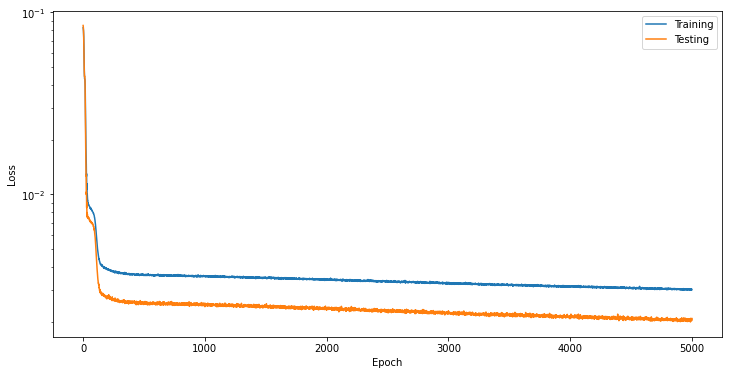

In [11]:
# Plotting the loss values
plt.figure(figsize=(12, 6))
plt.semilogy(train_loss_values, label='Training')
plt.semilogy(test_loss_values, label='Testing')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [12]:
X_train_reorg.shape

(2400, 290)

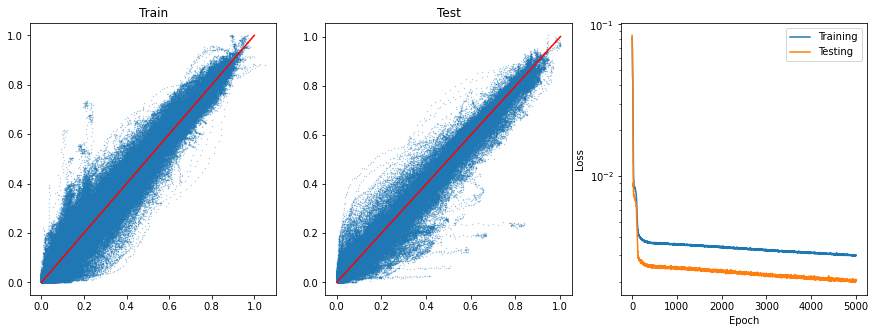

In [13]:
with torch.no_grad():
    X_train_pred,_,_ = model(torch.Tensor(X_train_reorg).to(device))
    X_train_pred = X_train_pred.squeeze().cpu().numpy()    
    
    X_test_pred,_,_ = model(torch.Tensor(X_test_reorg).to(device))
    X_test_pred = X_test_pred.squeeze().cpu().numpy()
    
fig, [ax1, ax2, ax3, ] = plt.subplots(1,3, figsize=(15,5))
ax1.scatter(X_train_pred.flatten(), X_train_reorg.flatten(), alpha = 0.5, s = 0.1)
ax1.plot([0,X_train_reorg.max()],[0,X_train_reorg.max()], color = 'red')
ax1.set_title("Train")

ax2.scatter(X_test_reorg.flatten(), X_test_pred.flatten(), alpha = 0.5, s = 0.1)
ax2.plot([0,X_test_reorg.max()],[0,X_test_reorg.max()], color = 'red')
ax2.set_title("Test")

ax3.semilogy(train_loss_values, label='Training')
ax3.semilogy(test_loss_values, label='Testing')
ax3.set_xlabel('Epoch')
ax3.set_ylabel('Loss')
ax3.legend()

plt.show()

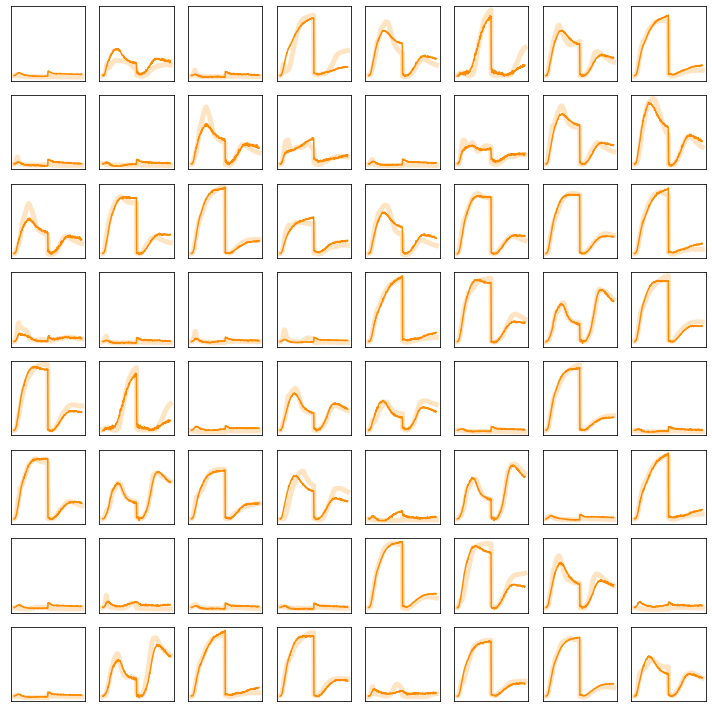

In [14]:
fig, axs = plt.subplots(8, 8, figsize = (10,10), sharex = True, sharey = "row")
for ax in axs.flatten():
    j = np.random.randint(X_test_reorg.shape[0])
    ax.plot( X_train_reorg[j,:], color = 'bisque', lw = 5)
    ax.plot( X_train_pred[j,:], color = 'darkorange', linestyle = '-')
    ax.set_xticks([])
    ax.set_yticks([])

    
plt.tight_layout()
plt.show()

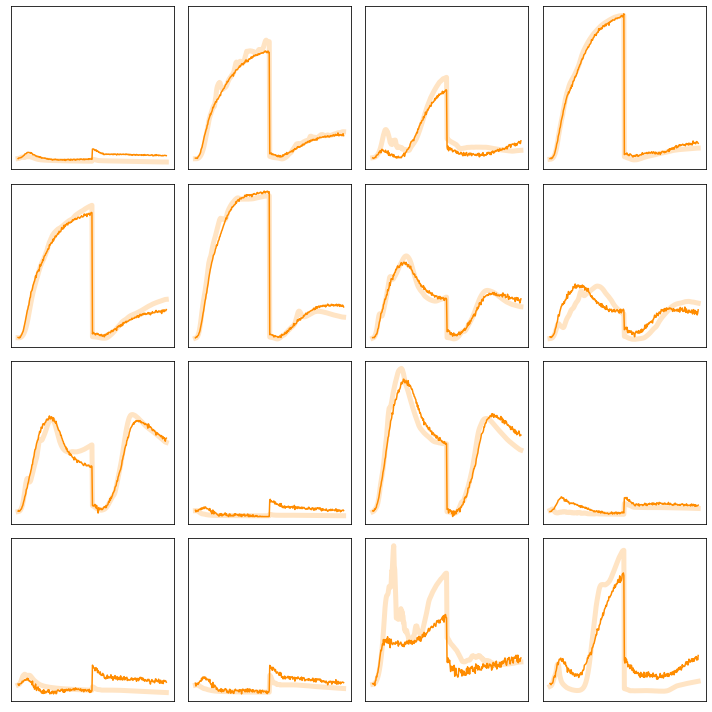

In [15]:
fig, axs = plt.subplots(4, 4, figsize = (10,10), sharex = True, sharey = "row")
for ax in axs.flatten():
    j = np.random.randint(X_test_reorg.shape[0])
    ax.plot( X_test_reorg[j,:], color = 'bisque', lw = 5)
    ax.plot( X_test_pred[j,:], color = 'darkorange', linestyle = '-')
    ax.set_xticks([])
    ax.set_yticks([])
    
#     twin = ax.twinx()
    
#     twin.plot(np.arange(144,289,1), X_test_reorg[j,145:], color = 'lightgreen', linestyle = '-', lw = 5)
#     twin.plot(np.arange(144,289,1), X_test_pred[j,145:], color = 'darkgreen', linestyle = '--')
    
plt.tight_layout()
plt.show()

## MLP Prediction

We will now need to use our trained VAE model to predict the true parameters for the system. 

In [16]:
# Load the ten parameters of the system
Y_train = np.load("./data/training_labels.npy")
Y_test = np.load("./data/testing_labels.npy")

# 0 - 1 Normalize
label_scaler = MinMaxScaler()
Y_train = label_scaler.fit_transform(Y_train)
Y_test = label_scaler.transform(Y_test)

Let's now define an MLP to map from the trained encoder to the parameter space. 

In [17]:
class MLP(nn.Module):
    def __init__(self, initial_dim, hidden_dim, final_dim, depth):
        super(MLP, self).__init__()
        # List to hold all layers
        layers = []
        
        # Initial layer
        layers.append(nn.Linear(initial_dim, hidden_dim))
        layers.append(nn.ReLU())
        
        # Hidden layers
        for _ in range(depth - 1):  # Subtract 1 since the first layer is already added
            layers.append(nn.Linear(hidden_dim, hidden_dim))
            layers.append(nn.ReLU())
        
        # Final layer
        layers.append(nn.Linear(hidden_dim, final_dim))
        
        # Create the network using nn.Sequential
        self.net = nn.Sequential(*layers)
        
    def forward(self, x):
        return self.net(x)

Lastly, define a combined model which integrates both an MLP and decoder. 

In [18]:
class VAEMapper(nn.Module):
    def __init__(self, trained_vae_decoder, mlp_initial_dim, mlp_hidden_dim, mlp_final_dim, mlp_depth):
        super(VAEMapper, self).__init__()
        
        # Freeze the parameters of the trained VAE encoder and put it in eval mode
        for param in trained_vae_decoder.parameters():
            param.requires_grad = False
        trained_vae_decoder.eval()
        
        self.vae_decoder = trained_vae_decoder
        self.mlp = MLP(mlp_initial_dim, mlp_hidden_dim, mlp_final_dim, mlp_depth)
        
    def forward(self, x):
        embed =  self.mlp(x) 
        return self.vae_decoder(embed)

Let's now define the hyperparameters of the system 

In [19]:
mlp_initial_dim = 11
mlp_hidden_dim  = 40
mlp_depth = 4
mlp_final_dim = latent_dim

In [20]:
# Lastly we define the model
mapper = VAEMapper(model.decoder, mlp_initial_dim, mlp_hidden_dim, mlp_final_dim, mlp_depth).to(device)
mapper;

Now we train the model. We define training parameters. 

In [43]:
lr= 2.5e-4
epochs = 300

In [44]:
mapper = mapper.to(device)
print(f'The model has {count_parameters(mapper):,} parameters')
criterion = nn.MSELoss()
optimizer = optim.Adam(mapper.mlp.parameters(), lr= lr,)

The model has 5,810 parameters


Let's now construct a dataloader:

In [45]:
from torch.utils.data import Dataset, DataLoader

class ParamSet(Dataset):
    def __init__(self, X_data, Y_data):
        self.X_data = torch.Tensor(X_data)
        self.Y_data = torch.Tensor(Y_data)

    def __len__(self):
        return len(self.X_data)

    def __getitem__(self, index):
        return self.X_data[index], self.Y_data[index]

In [46]:
#Configure the datasets
train_params = ParamSet(Y_train, train_data)
test_params = ParamSet(Y_test, test_data)

train_loader = torch.utils.data.DataLoader(train_params, batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_params, batch_size=batch_size, shuffle=False)

Now let's write the actual training loop: 

In [47]:
training_loss = []
testing_loss = []
for epoch in trange(epochs):
    
    # Put the model into training mode
    model.train()
    running_loss = 0.0
    
    # First compute the training loss
    for curves, labels in train_loader:

        curves = curves.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        
        pred = mapper(curves)
        loss = criterion(pred, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item() * curves.shape[0]
        
    epoch_loss = running_loss / len(train_loader.dataset)
    training_loss.append(epoch_loss)
    
        
    mapper.eval()
    running_loss = 0
    with torch.no_grad():
        for curves, labels in test_loader:
            curves = curves.to(device)
            labels = labels.to(device)
            
            pred = mapper(curves)
            loss = criterion(pred, labels)

            running_loss += loss.item() * curves.shape[0]
    
    epoch_loss = running_loss / len(test_loader.dataset)
    testing_loss.append(epoch_loss)
        
    
    if epoch % 250 == 0:
        print("Train: ", np.around(training_loss[epoch], 8) , "Test: ", np.around(testing_loss[epoch], 8) ) 

  0%|          | 0/300 [00:00<?, ?it/s]

Train:  0.00279542 Test:  0.00376788
Train:  0.00209938 Test:  0.00225664


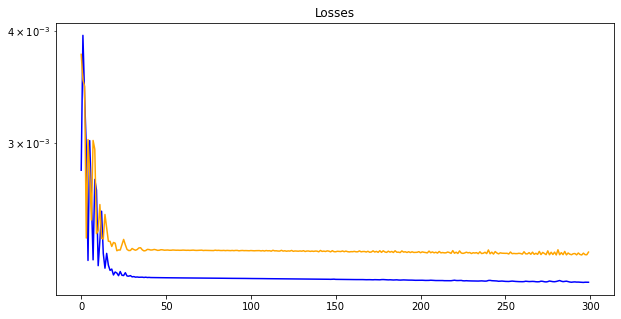

In [48]:
plt.figure(figsize = (10,5))
plt.title("Losses")
plt.semilogy(training_loss, label = 'Training', color = 'blue')
plt.semilogy(testing_loss,  label = 'Testing', color = 'orange' )
plt.show()

0.9606022519981037


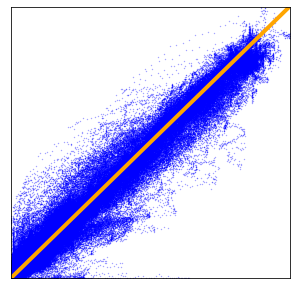

In [49]:
plt.figure(figsize = (5,5))
plt.scatter(X_test_reorg.flatten(), X_test_pred.flatten(), s=0.1, color='blue', alpha=0.5)
plt.plot([X_test_reorg.min(), X_test_reorg.max()], [X_test_reorg.min(), X_test_reorg.max()], color = 'orange', lw = 4)
#plt.set_title("Test Performance")
plt.xlim(X_test_reorg.min(), X_test_reorg.max())
plt.ylim(X_test_reorg.min(), X_test_reorg.max())
r2 = r2_score(X_test_reorg.flatten(), X_test_pred.flatten(),)
print(r2)
plt.xticks([])
plt.yticks([])
plt.show()

Let's now visualize the prediction performance: 

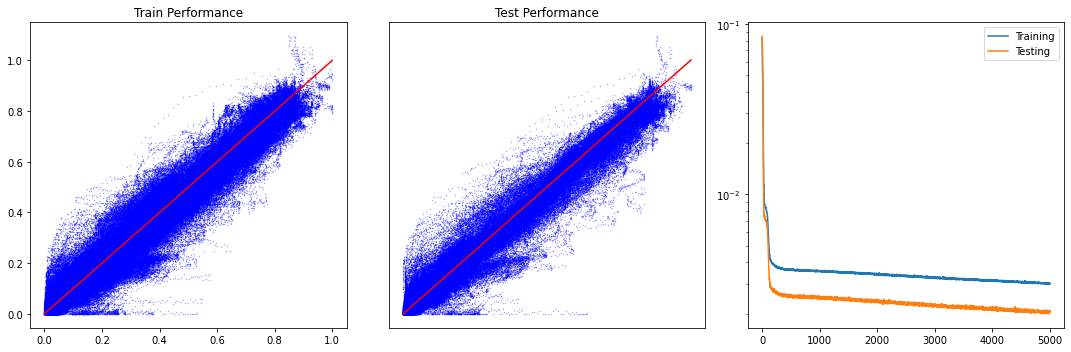

In [50]:
# Analyze the train performance
X_train_pred = (mapper(torch.Tensor(Y_train).to(device)).squeeze().detach().cpu().numpy())
X_test_pred = (mapper(torch.Tensor(Y_test).to(device)).squeeze().detach().cpu().numpy())

# Analyze output
fig, [ax1, ax2, ax3] = plt.subplots(1, 3, figsize = (15,5),)
ax1.scatter(X_train_reorg.flatten(), X_train_pred.flatten(), s=0.1, color='blue', alpha=0.5) 
ax1.plot([X_train_reorg.min(), X_train_reorg.max()], [X_train_reorg.min(), X_train_reorg.max()], color = 'red')
ax1.set_title("Train Performance")


ax2.scatter(X_test_reorg.flatten(), X_test_pred.flatten(), s=0.1, color='blue', alpha=0.5)
ax2.plot([X_test_reorg.min(), X_test_reorg.max()], [X_test_reorg.min(), X_test_reorg.max()], color = 'red')
ax2.set_title("Test Performance")
ax2.set_xticks([])
ax2.set_yticks([])


ax3.semilogy(train_loss_values, label='Training')
ax3.semilogy(test_loss_values, label='Testing')
#ax3.set_xlabel('Epoch')
#ax3.set_ylabel('Loss')
ax3.legend()
plt.tight_layout()

plt.show()

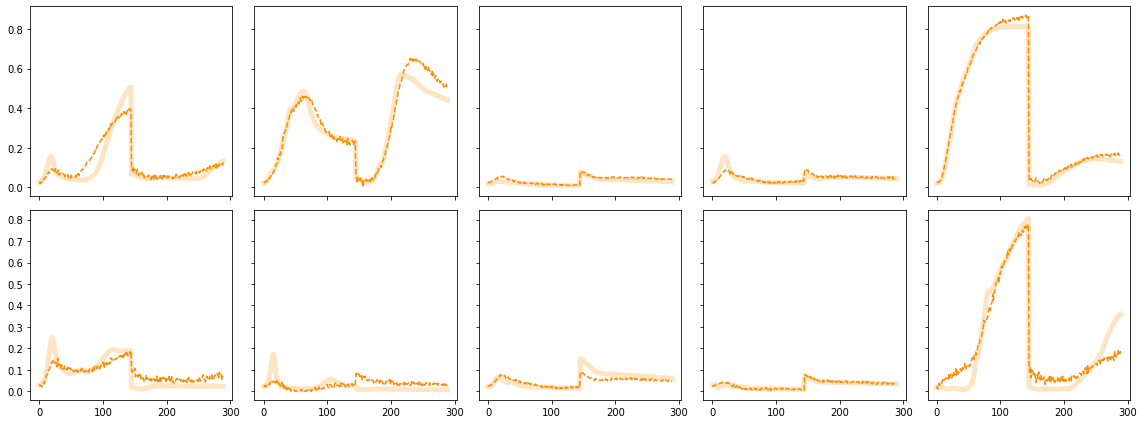

In [51]:
fig, axs = plt.subplots(2, 5, figsize = (16,6), sharex = True, sharey = "row")
for ax in axs.flatten():
    j = np.random.randint(X_train_reorg.shape[0])
    ax.plot(X_train_reorg[j,:], color = 'bisque', lw = 5)
    ax.plot(X_train_pred[j,:], color = 'darkorange', linestyle = '--')
    
plt.tight_layout()
plt.show()

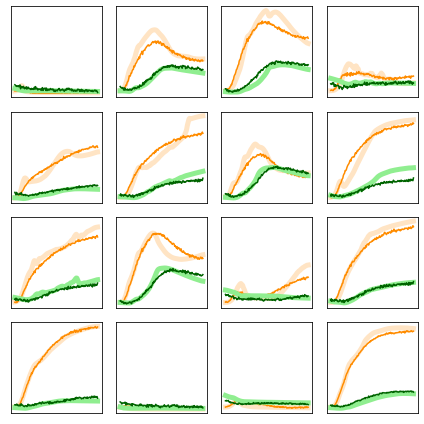

In [52]:
np.random.seed(40)
fig, axs = plt.subplots(4, 4, figsize = (6,6), sharex = True, sharey = "row")
for ax in axs.flatten():
    j = np.random.randint(X_test_reorg.shape[0])
#     ax.plot(X_test_reorg[j,:], color = 'bisque', lw = 5)
#     ax.plot(np.arange(145,290,1), X_test_reorg[j,145:], color = 'lightgreen', lw = 5)
#     ax.plot(X_test_pred[j,:], color = 'black', linestyle = '--')
#     ax.plot(np.arange(145,290,1),X_test_pred[j,145:], color = 'darkgreen', linestyle = '--')
    
    ax.plot(X_test_reorg[j,0:145], color = 'bisque', lw = 5)
    ax.plot(X_test_pred[j,0:145], color = 'darkorange', linestyle = '-')
    
#     twin = ax.twinx()
    
    ax.plot(X_test_reorg[j,145:], color = 'lightgreen', linestyle = '-', lw = 5)
    ax.plot(X_test_pred[j,145:], color = 'darkgreen', linestyle = '-')
    ax.set_xticks([])
    #ax.tick_params(axis=u'both', which=u'both',length=0)
    ax.set_yticks([])
    
    
plt.tight_layout()
plt.show()

In [53]:
# torch.save(mapper, f"./parameters/mapper_com_{latent_dim}.pt")